# Домашнее задание 3

Возьмите датасет с токсичными / нейтральными комментариями на русском языке:

https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments/data

Разделите датасет на обучающую и тестовую выборки. В качестве тестовой выборки
отделите 10% от всех данны
х.
Обучите бинарный классификатор на обучающей выборке, замерьте метрику F-score на
тестовой выбо
рке.
Вы можете использовать как линейные модели, так и дообучать трансформеры. Можно
обучить несколько разных классификаторов и сравнить их качество.

**Импорт библиотек**

In [1]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pymorphy3
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
import evaluate
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
from typing import Optional
from tqdm.auto import tqdm
from typing import Literal  

import warnings
warnings.filterwarnings('ignore')

**Загрузка датасета**

In [2]:
data = pd.read_csv(r"C:\Users\neytr\3. Binary Classification\labeled.csv")

**Выведем первые 5 строк датасета**

In [3]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


**Проверим на наличие нулевых значений**

In [4]:
data.isnull().sum()

comment    0
toxic      0
dtype: int64

**Выведем распределение датасета по токсичности**

<Axes: xlabel='toxic'>

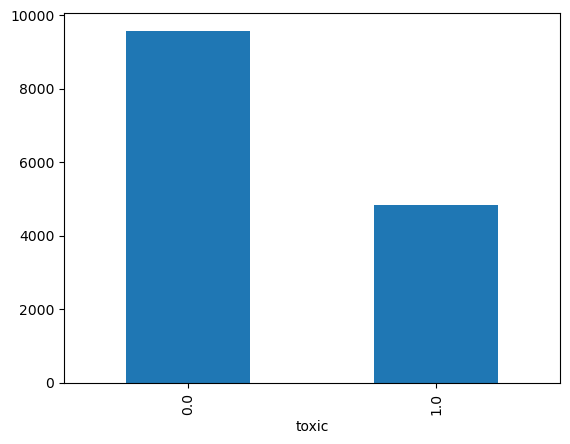

In [5]:
toxic_distr = data['toxic'].value_counts()
toxic_distr.plot(kind='bar')

## Без предобработки текста

**Сначала используем сырой датасет, без предобработки, обучим на нем наши классификаторы и посмотрим их качество**

In [6]:
comments = data['comment'].values
labels = data['toxic'].values

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    comments,
    labels,
    test_size=0.1,
    random_state=1,
)
X_train[:3], Y_train[:3]

(array(['Ну я смотрю - давай, облей меня говном.\n',
        'Любимый мой анекдот. Ибо часто попадаются клиенты с вопросом- КУЛЕ ТАК ДОРОГО??? Работаю автоэлектриком',
        'Все зависит от региона. В своей области я устраивался и зп была 15-18к, а клиентоориентированность похоже покурить вышла, установка одна - абонент всегда врет, если хочет отключиться - делай что хочешь, но 5 возражений должен отработать. И на сладкое. Меня лишили части зарплаты, за то что программа зафиксоровала мое якобы отсутствие в течении 3-4х часов, на протяжении месяца.\n'],
       dtype=object),
 array([1., 0., 0.]))

In [8]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(Y_train)}')
print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(Y_test)}')

len(X_train) = 12970
len(y_train) = 12970
len(X_test) = 1442
len(y_test) = 1442


### Применим сначала Bag-of-words model для представления текста

In [9]:
c_vect = CountVectorizer(max_features=30_000)
X_train_bow = c_vect.fit_transform(X_train)
X_test_bow = c_vect.transform(X_test)

**Обучим наши классификаторы:**

**Логистическая регрессия**

In [10]:
%%time
logreg = LogisticRegression(random_state= 1)
logreg.fit(X_train_bow, Y_train)
logreg_predict = logreg.predict(X_test_bow)
print(classification_report(Y_test, logreg_predict))

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90       948
         1.0       0.84      0.71      0.77       494

    accuracy                           0.86      1442
   macro avg       0.85      0.82      0.83      1442
weighted avg       0.86      0.86      0.85      1442

CPU times: total: 1.52 s
Wall time: 261 ms


**Линейный метод опорных векторов**

In [11]:
%%time
linsvc = LinearSVC(random_state= 1)
linsvc.fit(X_train_bow, Y_train)
linsvc_predict = linsvc.predict(X_test_bow)
print(classification_report(Y_test, linsvc_predict))

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       948
         1.0       0.78      0.74      0.76       494

    accuracy                           0.84      1442
   macro avg       0.83      0.82      0.82      1442
weighted avg       0.84      0.84      0.84      1442

CPU times: total: 1.31 s
Wall time: 387 ms


**Дерево решений**

In [12]:
%%time
dectree = DecisionTreeClassifier(random_state= 1)
dectree.fit(X_train_bow, Y_train)
dectree_predict = dectree.predict(X_test_bow)
print(classification_report(Y_test, dectree_predict))

              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81       948
         1.0       0.63      0.57      0.60       494

    accuracy                           0.74      1442
   macro avg       0.71      0.70      0.70      1442
weighted avg       0.73      0.74      0.74      1442

CPU times: total: 3.48 s
Wall time: 3.48 s


**Случайный лес**

In [13]:
%%time
randfor = RandomForestClassifier(random_state= 1)
randfor.fit(X_train_bow, Y_train)
randfor_predict = randfor.predict(X_test_bow)
print(classification_report(Y_test, randfor_predict))

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85       948
         1.0       0.77      0.56      0.65       494

    accuracy                           0.79      1442
   macro avg       0.79      0.74      0.75      1442
weighted avg       0.79      0.79      0.78      1442

CPU times: total: 37.3 s
Wall time: 37.3 s


**Гауссовский наивный байесовский классификатор**

In [14]:
%%time
GNB = GaussianNB()
GNB.fit(X_train_bow.toarray(), Y_train)
GNB_predict = GNB.predict(X_test_bow.toarray())
print(classification_report(Y_test, GNB_predict))

              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81       948
         1.0       0.63      0.78      0.70       494

    accuracy                           0.77      1442
   macro avg       0.75      0.77      0.76      1442
weighted avg       0.79      0.77      0.77      1442

CPU times: total: 4.05 s
Wall time: 4.05 s


**Мультиномиальный наивный байесовский классификатор**

In [15]:
%%time
MNB = MultinomialNB()
MNB.fit(X_train_bow, Y_train)
MNB_predict = MNB.predict(X_test_bow)
print(classification_report(Y_test, MNB_predict))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91       948
         1.0       0.87      0.74      0.80       494

    accuracy                           0.87      1442
   macro avg       0.87      0.84      0.85      1442
weighted avg       0.87      0.87      0.87      1442

CPU times: total: 15.6 ms
Wall time: 11 ms


**K-ближайших соседей**

In [16]:
%%time
KNN = KNeighborsClassifier()
KNN.fit(X_train_bow, Y_train)
KNN_predict = KNN.predict(X_test_bow)
print(classification_report(Y_test, KNN_predict))

              precision    recall  f1-score   support

         0.0       0.79      0.47      0.59       948
         1.0       0.43      0.76      0.55       494

    accuracy                           0.57      1442
   macro avg       0.61      0.62      0.57      1442
weighted avg       0.67      0.57      0.58      1442

CPU times: total: 469 ms
Wall time: 462 ms


Из результата видно, что лучше всего себя показали следующие классификаторы:
1. Мультиномиальный наивный Байес
2. Логистическая регрессия
3. Линейный метод опорных векторов

#### Теперь подберем оптимальные гиперпараметры для классификаторов и посмотрим, насколько улучшатся показатели:

**Линейный метод опорных векторов**

In [17]:
linSVC_params = { 
                'C': np.arange(0.01,10,0.5),
                }
linsvc_optimized = GridSearchCV(linsvc, linSVC_params, cv=5, scoring='f1_weighted', return_train_score=True)
linsvc_optimized.fit(X_train_bow, Y_train)
linsvc_optimized.best_estimator_

LinearSVC(C=0.51, random_state=1)

In [18]:
linsvc_optimized.best_score_

0.84799136900515

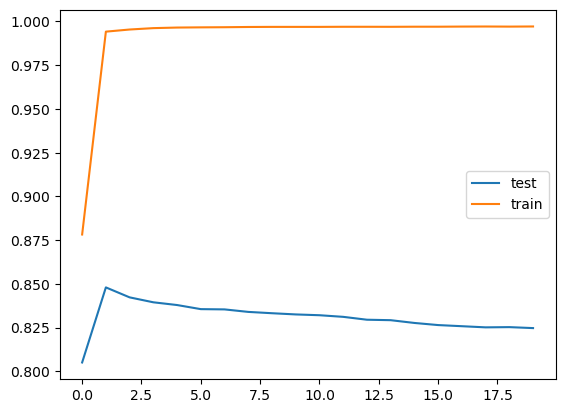

In [19]:
test_scores = linsvc_optimized.cv_results_['mean_test_score']
train_scores = linsvc_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [20]:
linsvc_optimized_predict = linsvc_optimized.predict(X_test_bow)
print(classification_report(Y_test, linsvc_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89       948
         1.0       0.80      0.74      0.77       494

    accuracy                           0.85      1442
   macro avg       0.83      0.82      0.83      1442
weighted avg       0.85      0.85      0.85      1442



**Дерево решений**

In [21]:
dectree_params = {
                  'max_depth': np.arange (80, 100, 10),
                  'min_samples_leaf': np.arange (1, 16, 4),
                  'min_samples_split': np.arange (80, 90, 1) 
                 }
dectree_optimized = GridSearchCV(dectree, dectree_params, cv=5, scoring='f1_weighted', return_train_score=True)
dectree_optimized.fit(X_train_bow, Y_train)
dectree_optimized.best_estimator_

DecisionTreeClassifier(max_depth=90, min_samples_split=88, random_state=1)

In [22]:
dectree_optimized.best_score_

0.7446431377530144

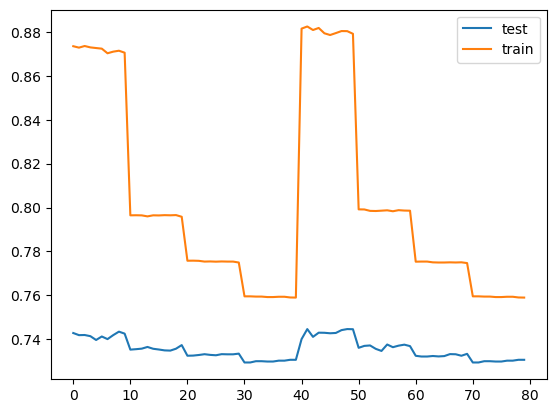

In [23]:
test_scores = dectree_optimized.cv_results_['mean_test_score']
train_scores = dectree_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [24]:
dectree_optimized_predict = dectree_optimized.predict(X_test_bow)
print(classification_report(Y_test, dectree_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82       948
         1.0       0.65      0.61      0.63       494

    accuracy                           0.75      1442
   macro avg       0.73      0.72      0.72      1442
weighted avg       0.75      0.75      0.75      1442



**Случайный лес**

In [25]:
randfor_params = { 
                'n_estimators': np.arange (50, 70, 5),
                'max_depth': np.arange (550,700, 50),
                'min_samples_leaf': np.arange (1,100, 20),
                'min_samples_split': np.arange (80,100,5) 
                 }
randfor_optimized = RandomizedSearchCV(randfor, randfor_params, cv=5, scoring='f1_weighted', return_train_score=True)
randfor_optimized.fit(X_train_bow, Y_train)
randfor_optimized.best_estimator_

RandomForestClassifier(max_depth=550, min_samples_split=85, n_estimators=60,
                       random_state=1)

In [26]:
randfor_optimized.best_score_

0.7684432840230111

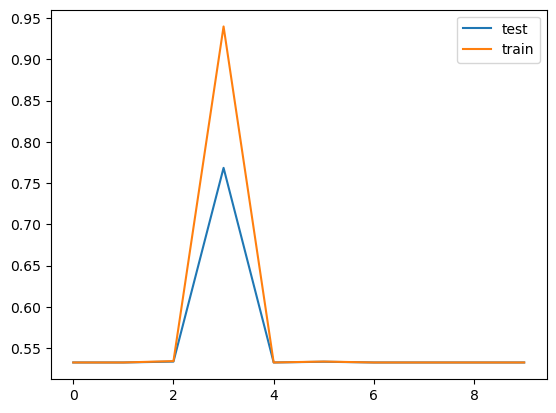

In [27]:
test_scores = randfor_optimized.cv_results_['mean_test_score']
train_scores = randfor_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [28]:
randfor_optimized_predict = randfor_optimized.predict(X_test_bow)
print(classification_report(Y_test, randfor_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       948
         1.0       0.79      0.50      0.62       494

    accuracy                           0.78      1442
   macro avg       0.79      0.72      0.73      1442
weighted avg       0.79      0.78      0.77      1442



**Мультиномиальный наивный байесовский классификатор**

In [29]:
MNB_params = { 
                'alpha' : np.arange (0.5, 0.7, 0.001)
             }
MNB_optimized = GridSearchCV(MNB, MNB_params, cv=5, scoring='f1_weighted', return_train_score=True)
MNB_optimized.fit(X_train_bow, Y_train)
MNB_optimized.best_estimator_

MultinomialNB(alpha=0.541)

In [30]:
MNB_optimized.best_score_

0.8784434570433494

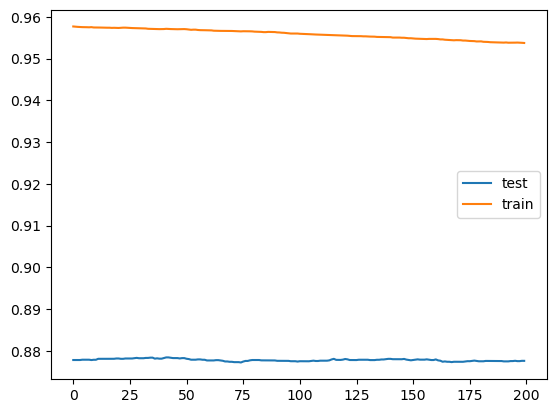

In [31]:
test_scores = MNB_optimized.cv_results_['mean_test_score']
train_scores = MNB_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [32]:
MNB_optimized_predict = MNB_optimized.predict(X_test_bow)
print(classification_report(Y_test, MNB_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       948
         1.0       0.86      0.78      0.81       494

    accuracy                           0.88      1442
   macro avg       0.87      0.85      0.86      1442
weighted avg       0.88      0.88      0.88      1442



**K-ближайших соседей**

In [33]:
KNN_params = { 
                'n_neighbors': np.arange (1, 20, 1)
             }
KNN_optimized = GridSearchCV(KNN, KNN_params, cv=5, scoring='f1_weighted', return_train_score=True)
KNN_optimized.fit(X_train_bow, Y_train)
KNN_optimized.best_estimator_

KNeighborsClassifier(n_neighbors=2)

In [34]:
KNN_optimized.best_score_

0.6306349628095772

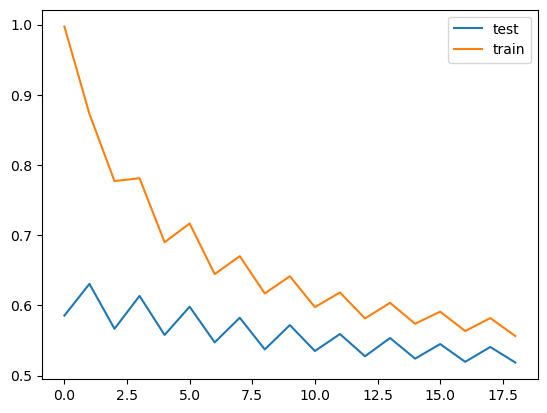

In [35]:
test_scores = KNN_optimized.cv_results_['mean_test_score']
train_scores = KNN_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [36]:
KNN_optimized_predict = KNN_optimized.predict(X_test_bow)
print(classification_report(Y_test, KNN_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       948
         1.0       0.44      0.45      0.45       494

    accuracy                           0.62      1442
   macro avg       0.58      0.58      0.58      1442
weighted avg       0.62      0.62      0.62      1442



Подбор оптимальных гиперпараметров дал хороший прирост в KNN, в остальных случая прирост не особо ощутимый.

### Теперь применим Term Frequency - Inverse Document Frequency method (TF-IDF) для представления текстов

In [37]:
idf_vect = TfidfVectorizer(max_features=30_000)
X_train_idf = idf_vect.fit_transform(X_train)
X_test_idf = idf_vect.transform(X_test)

**Логистическая регрессия**

In [38]:
%%time
logreg.fit(X_train_idf, Y_train)
logreg_predict = logreg.predict(X_test_idf)
print(classification_report(Y_test, logreg_predict))

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88       948
         1.0       0.88      0.60      0.71       494

    accuracy                           0.83      1442
   macro avg       0.85      0.78      0.80      1442
weighted avg       0.84      0.83      0.82      1442

CPU times: total: 1.5 s
Wall time: 256 ms


**Линейный метод опорных векторов**

In [39]:
%%time
linsvc.fit(X_train_idf, Y_train)
linsvc_predict = linsvc.predict(X_test_idf)
print(classification_report(Y_test, linsvc_predict))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       948
         1.0       0.84      0.73      0.78       494

    accuracy                           0.86      1442
   macro avg       0.85      0.83      0.84      1442
weighted avg       0.86      0.86      0.86      1442

CPU times: total: 281 ms
Wall time: 47.5 ms


**Дерево решений**

In [40]:
%%time
dectree.fit(X_train_idf, Y_train)
dectree_predict = dectree.predict(X_test_idf)
print(classification_report(Y_test, dectree_predict))

              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80       948
         1.0       0.61      0.57      0.59       494

    accuracy                           0.73      1442
   macro avg       0.70      0.69      0.70      1442
weighted avg       0.73      0.73      0.73      1442

CPU times: total: 5.75 s
Wall time: 5.15 s


**Случайный лес**

In [41]:
%%time
randfor.fit(X_train_idf, Y_train)
randfor_predict = randfor.predict(X_test_idf)
print(classification_report(Y_test, randfor_predict))

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85       948
         1.0       0.76      0.52      0.62       494

    accuracy                           0.78      1442
   macro avg       0.77      0.72      0.73      1442
weighted avg       0.78      0.78      0.77      1442

CPU times: total: 37.5 s
Wall time: 37.5 s


**Гауссовский наивный байесовский классификатор**

In [42]:
%%time
GNB.fit(X_train_idf.toarray(), Y_train)
GNB_predict = GNB.predict(X_test_idf.toarray())
print(classification_report(Y_test, GNB_predict))

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82       948
         1.0       0.64      0.72      0.68       494

    accuracy                           0.77      1442
   macro avg       0.74      0.76      0.75      1442
weighted avg       0.78      0.77      0.77      1442

CPU times: total: 4 s
Wall time: 4 s


**Мультиномиальный наивный байесовский классификатор**

In [43]:
%%time
MNB.fit(X_train_idf, Y_train)
MNB_predict = MNB.predict(X_test_idf)
print(classification_report(Y_test, MNB_predict))

              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86       948
         1.0       0.94      0.38      0.54       494

    accuracy                           0.78      1442
   macro avg       0.85      0.68      0.70      1442
weighted avg       0.82      0.78      0.75      1442

CPU times: total: 15.6 ms
Wall time: 11 ms


**K-ближайших соседей**

In [44]:
%%time
KNN.fit(X_train_idf, Y_train)
KNN_predict = KNN.predict(X_test_idf)
print(classification_report(Y_test, KNN_predict))

              precision    recall  f1-score   support

         0.0       0.86      0.01      0.01       948
         1.0       0.34      1.00      0.51       494

    accuracy                           0.35      1442
   macro avg       0.60      0.50      0.26      1442
weighted avg       0.68      0.35      0.18      1442

CPU times: total: 10.9 s
Wall time: 1.02 s


В целом результаты примерно одинаковые, но здесь:
1. Линейный метод опорных векторов
2. Логистическая регрессия
3. Гауссовский наивый Байес/случайный лес

#### Теперь подберем оптимальные гиперпараметры для классификаторов и посмотрим, насколько улучшатся показатели:

**Линейный метод опорных векторов**

In [45]:
linSVC_params = { 
                'C': np.arange(0.01,10,0.5),
                }
linsvc_optimized = GridSearchCV(linsvc, linSVC_params, cv=5, scoring='f1_weighted', return_train_score=True)
linsvc_optimized.fit(X_train_idf, Y_train)
linsvc_optimized.best_estimator_

LinearSVC(C=1.01, random_state=1)

In [46]:
linsvc_optimized.best_score_

0.8591629961866396

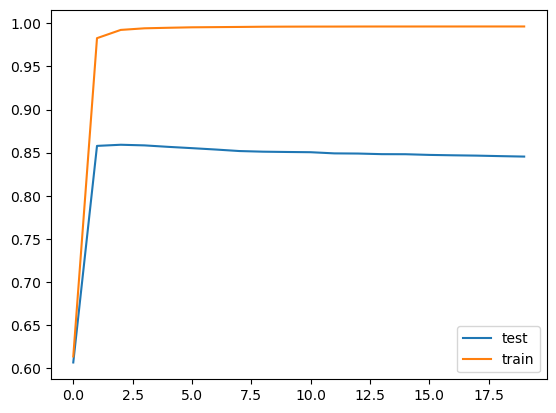

In [47]:
test_scores = linsvc_optimized.cv_results_['mean_test_score']
train_scores = linsvc_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [48]:
linsvc_optimized_predict = linsvc_optimized.predict(X_test_idf)
print(classification_report(Y_test, linsvc_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       948
         1.0       0.84      0.73      0.78       494

    accuracy                           0.86      1442
   macro avg       0.85      0.83      0.84      1442
weighted avg       0.86      0.86      0.86      1442



**Дерево решений**

In [49]:
dectree_params = {
                  'max_depth': np.arange (60, 120, 10),
                  'min_samples_leaf': np.arange (1, 16, 4),
                  'min_samples_split': np.arange (60, 100, 1) 
                 }
dectree_optimized = RandomizedSearchCV(dectree, dectree_params, cv=5, scoring='f1_weighted', return_train_score=True)
dectree_optimized.fit(X_train_idf, Y_train)
dectree_optimized.best_estimator_

DecisionTreeClassifier(max_depth=110, min_samples_split=88, random_state=1)

In [50]:
dectree_optimized.best_score_

0.7325077509063342

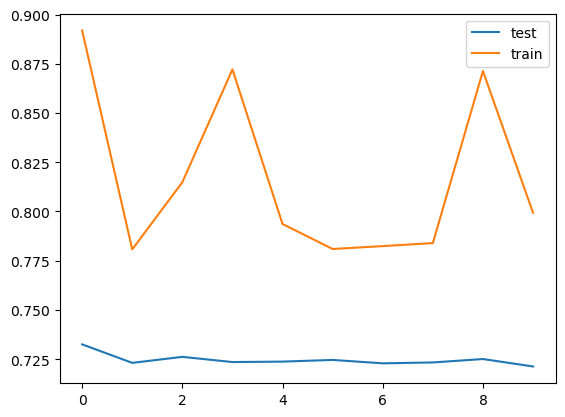

In [51]:
test_scores = dectree_optimized.cv_results_['mean_test_score']
train_scores = dectree_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [52]:
dectree_optimized_predict = dectree_optimized.predict(X_test_idf)
print(classification_report(Y_test, dectree_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.79      0.80      0.80       948
         1.0       0.61      0.60      0.61       494

    accuracy                           0.73      1442
   macro avg       0.70      0.70      0.70      1442
weighted avg       0.73      0.73      0.73      1442



**Случайный лес**

In [53]:
randfor_params = { 
                'n_estimators': np.arange (1, 100, 1),
                'max_depth': np.arange (1,1000, 20),
                'min_samples_leaf': np.arange (1,50, 1),
                'min_samples_split': np.arange (2,6,1) 
                 }
randfor_optimized = RandomizedSearchCV(randfor, randfor_params, cv=5, scoring='f1_weighted', return_train_score=True)
randfor_optimized.fit(X_train_idf, Y_train)
randfor_optimized.best_estimator_

RandomForestClassifier(max_depth=41, min_samples_leaf=3, n_estimators=12,
                       random_state=1)

In [54]:
randfor_optimized.best_score_

0.6439005992892726

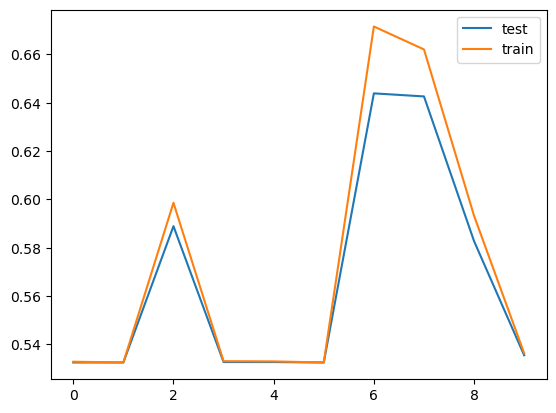

In [55]:
test_scores = randfor_optimized.cv_results_['mean_test_score']
train_scores = randfor_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [56]:
randfor_optimized_predict = randfor_optimized.predict(X_test_idf)
print(classification_report(Y_test, randfor_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.70      0.99      0.82       948
         1.0       0.89      0.20      0.33       494

    accuracy                           0.72      1442
   macro avg       0.80      0.60      0.58      1442
weighted avg       0.77      0.72      0.65      1442



**Мультиномиальный наивный байесовский классификатор**

In [57]:
MNB_params = { 
                'alpha' : np.arange (0.001, 0.7, 0.01)
             }
MNB_optimized = GridSearchCV(MNB, MNB_params, cv=5, scoring='f1_weighted', return_train_score=True)
MNB_optimized.fit(X_train_idf, Y_train)
MNB_optimized.best_estimator_

MultinomialNB(alpha=0.09099999999999998)

In [58]:
MNB_optimized.best_score_

0.8721590676059685

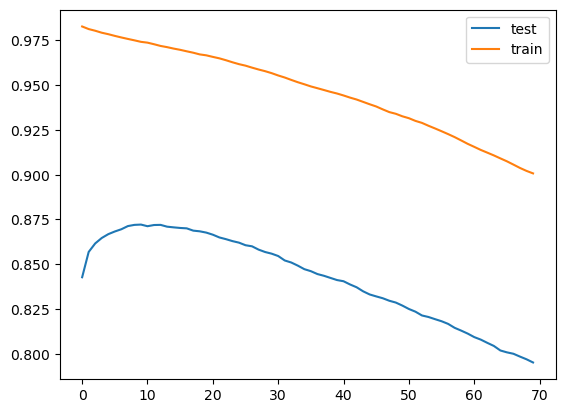

In [59]:
test_scores = MNB_optimized.cv_results_['mean_test_score']
train_scores = MNB_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [60]:
MNB_optimized_predict = MNB_optimized.predict(X_test_idf)
print(classification_report(Y_test, MNB_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.91       948
         1.0       0.89      0.70      0.79       494

    accuracy                           0.87      1442
   macro avg       0.88      0.83      0.85      1442
weighted avg       0.87      0.87      0.86      1442



**K-ближайших соседей**

In [61]:
KNN_params = { 
                'n_neighbors': np.arange (35, 60, 1)
             }
KNN_optimized = GridSearchCV(KNN, KNN_params, cv=5, scoring='f1_weighted', return_train_score=True)
KNN_optimized.fit(X_train_idf, Y_train)
KNN_optimized.best_estimator_

KNeighborsClassifier(n_neighbors=43)

In [62]:
KNN_optimized.best_score_

0.8349544417996502

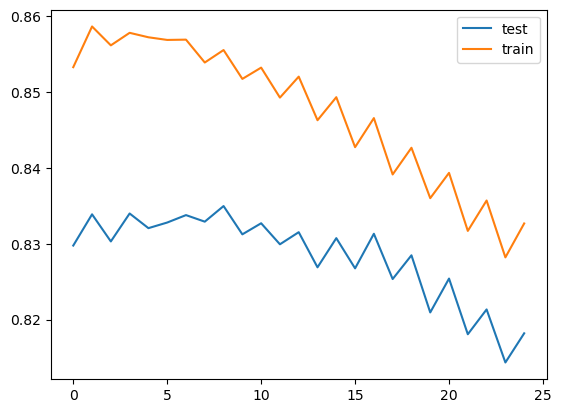

In [63]:
test_scores = KNN_optimized.cv_results_['mean_test_score']
train_scores = KNN_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [64]:
KNN_optimized_predict = KNN_optimized.predict(X_test_idf)
print(classification_report(Y_test, KNN_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87       948
         1.0       0.74      0.80      0.77       494

    accuracy                           0.84      1442
   macro avg       0.82      0.83      0.82      1442
weighted avg       0.84      0.84      0.84      1442



В данном случае очень хороший прирост у Мультиномиального наивного Байеса и KNN. Из-за того, что подбор гиперпараметров методом GridSearch в случаях Дерева Решений и Случайного леса может занимать слишком много времени, было принято решение заменить его на метод RandomizedSearch, который в некоторых случаях может не находить лучших решений.

## С предобработкой текста

**Теперь попробуем сначала предобработать текст, а потом уже обучать наши классификаторы для этого приведем весь текст к нижнему регистру, потом токенизируем слова, после применим методы Стемминга и Лемматизации, затем составим словарь слов, и обучим классификаторы.**

In [65]:
russian_stop_words = stopwords.words('russian')
stemmer = SnowballStemmer('russian')

def stemming_tokenizer(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens
    
def clean_df(df):
    df = df.str.lower()
    df = df.replace(r'[^а-яА-Я]', ' ', regex=True)
    df = df.replace(r'ё', 'е', regex=True)
    df = df.str.strip()
    return df

In [66]:
data_preprocessed_stem = data
data_preprocessed_stem['comment'] = clean_df(data_preprocessed_stem['comment'])

In [67]:
comments_preprocessed_stem = data_preprocessed_stem['comment'].values
lables_preprocessed_stem = data_preprocessed_stem['toxic'].values

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(
    comments_preprocessed_stem,
    lables_preprocessed_stem,
    test_size=0.1,
    random_state=1,
)

In [69]:
idf_stem_vect = TfidfVectorizer(tokenizer = lambda x: stemming_tokenizer(x, remove_stop_words = True), max_features=30_000)
X_train_idf_stem = idf_stem_vect.fit_transform(X_train)
X_test_idf_stem = idf_stem_vect.transform(X_test)

**Обучим наши классификаторы:**

**Логистическая регрессия**

In [70]:
%%time
logreg.fit(X_train_idf_stem, Y_train)
logreg_predict = logreg.predict(X_test_idf_stem)
print(classification_report(Y_test, logreg_predict))

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       948
         1.0       0.91      0.65      0.75       494

    accuracy                           0.86      1442
   macro avg       0.87      0.81      0.83      1442
weighted avg       0.86      0.86      0.85      1442

CPU times: total: 906 ms
Wall time: 145 ms


**Линейный метод опорных векторов**

In [71]:
%%time
linsvc.fit(X_train_idf_stem, Y_train)
linsvc_predict = linsvc.predict(X_test_idf_stem)
print(classification_report(Y_test, linsvc_predict))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       948
         1.0       0.87      0.77      0.82       494

    accuracy                           0.88      1442
   macro avg       0.88      0.85      0.86      1442
weighted avg       0.88      0.88      0.88      1442

CPU times: total: 281 ms
Wall time: 39 ms


**Дерево решений**

In [72]:
%%time
dectree.fit(X_train_idf_stem, Y_train)
dectree_predict = dectree.predict(X_test_idf_stem)
print(classification_report(Y_test, dectree_predict))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       948
         1.0       0.73      0.62      0.67       494

    accuracy                           0.79      1442
   macro avg       0.77      0.75      0.76      1442
weighted avg       0.79      0.79      0.79      1442

CPU times: total: 6.05 s
Wall time: 5.37 s


**Случайный лес**

In [73]:
%%time
randfor.fit(X_train_idf_stem, Y_train)
randfor_predict = randfor.predict(X_test_idf_stem)
print(classification_report(Y_test, randfor_predict))

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89       948
         1.0       0.88      0.62      0.72       494

    accuracy                           0.84      1442
   macro avg       0.85      0.79      0.81      1442
weighted avg       0.84      0.84      0.83      1442

CPU times: total: 32.7 s
Wall time: 32.7 s


**Гауссовский наивный байесовский классификатор**

In [74]:
%%time
GNB.fit(X_train_idf_stem.toarray(), Y_train)
GNB_predict = GNB.predict(X_test_idf_stem.toarray())
print(classification_report(Y_test, GNB_predict))

              precision    recall  f1-score   support

         0.0       0.83      0.68      0.74       948
         1.0       0.54      0.73      0.62       494

    accuracy                           0.69      1442
   macro avg       0.68      0.70      0.68      1442
weighted avg       0.73      0.69      0.70      1442

CPU times: total: 3.83 s
Wall time: 3.88 s


**Мультиномиальный наивный байесовский классификатор**

In [75]:
%%time
MNB.fit(X_train_idf_stem, Y_train)
MNB_predict = MNB.predict(X_test_idf_stem)
print(classification_report(Y_test, MNB_predict))

              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87       948
         1.0       0.95      0.46      0.62       494

    accuracy                           0.81      1442
   macro avg       0.86      0.72      0.75      1442
weighted avg       0.84      0.81      0.78      1442

CPU times: total: 15.6 ms
Wall time: 10 ms


**K-ближайших соседей**

In [76]:
%%time
KNN.fit(X_train_idf_stem, Y_train)
KNN_predict = KNN.predict(X_test_idf_stem)
print(classification_report(Y_test, KNN_predict))

              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80       948
         1.0       0.87      0.07      0.13       494

    accuracy                           0.68      1442
   macro avg       0.77      0.53      0.46      1442
weighted avg       0.74      0.68      0.57      1442

CPU times: total: 6.89 s
Wall time: 629 ms


В целом качество улучшилось, и начал выигрывать такой метод, как случайный лес.

#### Теперь подберем оптимальные гиперпараметры для классификаторов и посмотрим, насколько улучшатся показатели:

**Линейный метод опорных векторов**

In [77]:
linSVC_params = { 
                'C': np.arange(0.01,10,0.5),
                }
linsvc_optimized = GridSearchCV(linsvc, linSVC_params, cv=5, scoring='f1_weighted', return_train_score=True)
linsvc_optimized.fit(X_train_idf_stem, Y_train)
linsvc_optimized.best_estimator_

LinearSVC(C=1.01, random_state=1)

In [78]:
linsvc_optimized.best_score_

0.8694849487961033

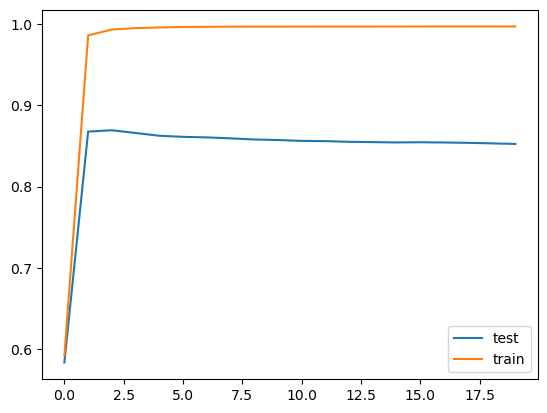

In [79]:
test_scores = linsvc_optimized.cv_results_['mean_test_score']
train_scores = linsvc_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [80]:
linsvc_optimized_predict = linsvc_optimized.predict(X_test_idf_stem)
print(classification_report(Y_test, linsvc_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       948
         1.0       0.87      0.77      0.82       494

    accuracy                           0.88      1442
   macro avg       0.88      0.85      0.86      1442
weighted avg       0.88      0.88      0.88      1442



**Дерево решений**

In [81]:
dectree_params = {
                  'max_depth': np.arange (80, 140, 10),
                  'min_samples_leaf': np.arange (1, 16, 4),
                  'min_samples_split': np.arange (60, 100, 1) 
                 }
dectree_optimized = RandomizedSearchCV(dectree, dectree_params, cv=5, scoring='f1_weighted', return_train_score=True)
dectree_optimized.fit(X_train_idf_stem, Y_train)
dectree_optimized.best_estimator_

DecisionTreeClassifier(max_depth=120, min_samples_leaf=5, min_samples_split=69,
                       random_state=1)

In [82]:
dectree_optimized.best_score_

0.7662704311825036

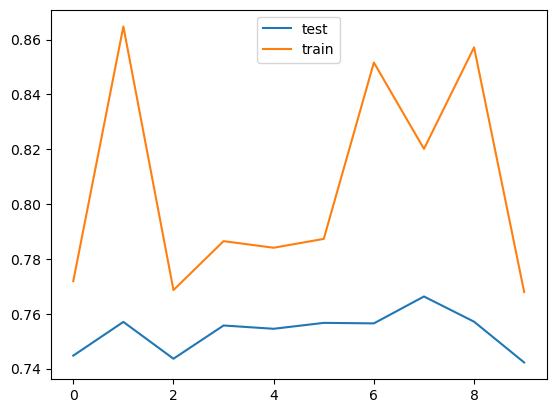

In [83]:
test_scores = dectree_optimized.cv_results_['mean_test_score']
train_scores = dectree_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [84]:
dectree_optimized_predict = dectree_optimized.predict(X_test_idf_stem)
print(classification_report(Y_test, dectree_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.78      0.95      0.86       948
         1.0       0.83      0.49      0.62       494

    accuracy                           0.79      1442
   macro avg       0.80      0.72      0.74      1442
weighted avg       0.80      0.79      0.77      1442



**Случайный лес**

In [85]:
randfor_params = { 
                'n_estimators': np.arange (10, 110, 1),
                'max_depth': np.arange (1,1000, 20),
                'min_samples_leaf': np.arange (1,50, 1),
                'min_samples_split': np.arange (2,6,1) 
                 }
randfor_optimized = RandomizedSearchCV(randfor, randfor_params, cv=5, scoring='f1_weighted', return_train_score=True)
randfor_optimized.fit(X_train_idf_stem, Y_train)
randfor_optimized.best_estimator_

RandomForestClassifier(max_depth=801, min_samples_leaf=7, min_samples_split=5,
                       n_estimators=63, random_state=1)

In [86]:
randfor_optimized.best_score_

0.7696851103418462

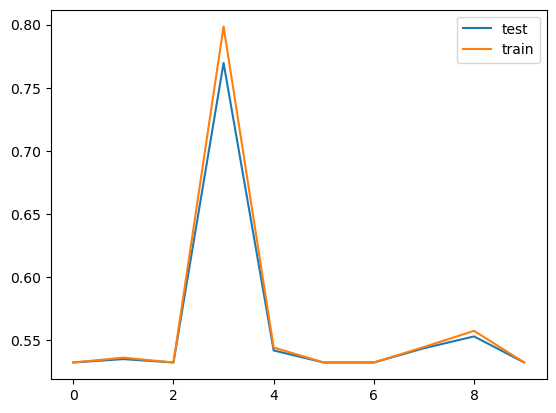

In [87]:
test_scores = randfor_optimized.cv_results_['mean_test_score']
train_scores = randfor_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [88]:
randfor_optimized_predict = randfor_optimized.predict(X_test_idf_stem)
print(classification_report(Y_test, randfor_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86       948
         1.0       0.91      0.45      0.60       494

    accuracy                           0.80      1442
   macro avg       0.84      0.71      0.73      1442
weighted avg       0.82      0.80      0.77      1442



**Мультиномиальный наивный байесовский классификатор**

In [89]:
MNB_params = { 
                'alpha' : np.arange (0.001, 0.7, 0.01)
             }
MNB_optimized = GridSearchCV(MNB, MNB_params, cv=5, scoring='f1_weighted', return_train_score=True)
MNB_optimized.fit(X_train_idf_stem, Y_train)
MNB_optimized.best_estimator_

MultinomialNB(alpha=0.10099999999999998)

In [90]:
MNB_optimized.best_score_

0.8796371763199409

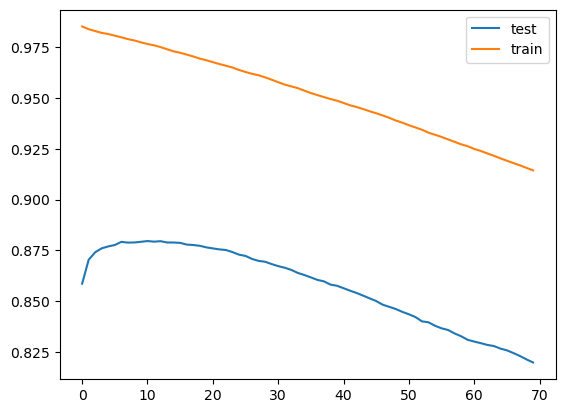

In [91]:
test_scores = MNB_optimized.cv_results_['mean_test_score']
train_scores = MNB_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [92]:
MNB_optimized_predict = MNB_optimized.predict(X_test_idf_stem)
print(classification_report(Y_test, MNB_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91       948
         1.0       0.86      0.74      0.80       494

    accuracy                           0.87      1442
   macro avg       0.87      0.84      0.85      1442
weighted avg       0.87      0.87      0.87      1442



**K-ближайших соседей**

In [93]:
KNN_params = { 
                'n_neighbors': np.arange (20, 40, 1)
             }
KNN_optimized = GridSearchCV(KNN, KNN_params, cv=5, scoring='f1_weighted', return_train_score=True)
KNN_optimized.fit(X_train_idf_stem, Y_train)
KNN_optimized.best_estimator_

KNeighborsClassifier(n_neighbors=23)

In [94]:
KNN_optimized.best_score_

0.7900805969283902

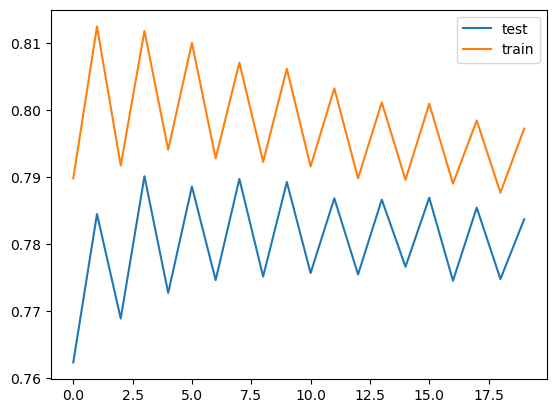

In [95]:
test_scores = KNN_optimized.cv_results_['mean_test_score']
train_scores = KNN_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [96]:
KNN_optimized_predict = KNN_optimized.predict(X_test_idf_stem)
print(classification_report(Y_test, KNN_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87       948
         1.0       0.95      0.48      0.63       494

    accuracy                           0.81      1442
   macro avg       0.87      0.73      0.75      1442
weighted avg       0.84      0.81      0.79      1442



После подбора гиперпараметров сильный прирост заметен у KNN и случайного леса. Из-за того, что подбор гиперпараметров методом GridSearch в случаях Дерева Решений и Случайного леса может занимать слишком много времени, было принято решение заменить его на метод RandomizedSearch, который в некоторых случаях может не находить лучших решений.

**Выше мы применили Стемминг во время преобратоки текста, теперь применим Лемматизацию, что на мой взгляд более лучший подход к предобработке текста, т.к. при стемминге многие однокоренные слова приводятся непрпавильно к своему первоначалу из-за чего будет неточно посчитана мера TF-IDF:**

**Для лемматизации будем использовать лемматизатор из Pymorphy3**

In [97]:
morph = pymorphy3.MorphAnalyzer()
def lemmatization_tokenizer(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [morph.parse(i)[0].normal_form for i in tokens]
    return tokens

In [98]:
data_preprocessed_lemm = data
data_preprocessed_lemm['comment'] = clean_df(data_preprocessed_lemm['comment'])

In [99]:
comments_preprocessed_lemm = data_preprocessed_lemm['comment'].values
lables_preprocessed_lemm = data_preprocessed_lemm['toxic'].values

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(
    comments_preprocessed_lemm,
    lables_preprocessed_lemm,
    test_size=0.1,
    random_state=1,
)

In [101]:
idf_lemm_vect = TfidfVectorizer(tokenizer = lambda x: lemmatization_tokenizer(x, remove_stop_words = True), max_features=30_000)
X_train_idf_lemm = idf_stem_vect.fit_transform(X_train)
X_test_idf_lemm = idf_stem_vect.transform(X_test)

**Логистическая регрессия**

In [102]:
%%time
logreg.fit(X_train_idf_lemm, Y_train)
logreg_predict = logreg.predict(X_test_idf_lemm)
print(classification_report(Y_test, logreg_predict))

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       948
         1.0       0.91      0.65      0.75       494

    accuracy                           0.86      1442
   macro avg       0.87      0.81      0.83      1442
weighted avg       0.86      0.86      0.85      1442

CPU times: total: 1.09 s
Wall time: 308 ms


**Линейный метод опорных векторов**

In [103]:
%%time
linsvc.fit(X_train_idf_lemm, Y_train)
linsvc_predict = linsvc.predict(X_test_idf_lemm)
print(classification_report(Y_test, linsvc_predict))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       948
         1.0       0.87      0.77      0.82       494

    accuracy                           0.88      1442
   macro avg       0.88      0.85      0.86      1442
weighted avg       0.88      0.88      0.88      1442

CPU times: total: 188 ms
Wall time: 37 ms


**Дерево решений**

In [104]:
%%time
dectree.fit(X_train_idf_lemm, Y_train)
dectree_predict = dectree.predict(X_test_idf_lemm)
print(classification_report(Y_test, dectree_predict))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       948
         1.0       0.73      0.62      0.67       494

    accuracy                           0.79      1442
   macro avg       0.77      0.75      0.76      1442
weighted avg       0.79      0.79      0.79      1442

CPU times: total: 6.2 s
Wall time: 5.43 s


**Случайный лес**

In [105]:
%%time
randfor.fit(X_train_idf_lemm, Y_train)
randfor_predict = randfor.predict(X_test_idf_lemm)
print(classification_report(Y_test, randfor_predict))

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89       948
         1.0       0.88      0.62      0.72       494

    accuracy                           0.84      1442
   macro avg       0.85      0.79      0.81      1442
weighted avg       0.84      0.84      0.83      1442

CPU times: total: 33 s
Wall time: 33 s


**Гауссовский наивный байесовский классификатор**

In [106]:
%%time
GNB.fit(X_train_idf_lemm.toarray(), Y_train)
GNB_predict = GNB.predict(X_test_idf_lemm.toarray())
print(classification_report(Y_test, GNB_predict))

              precision    recall  f1-score   support

         0.0       0.83      0.68      0.74       948
         1.0       0.54      0.73      0.62       494

    accuracy                           0.69      1442
   macro avg       0.68      0.70      0.68      1442
weighted avg       0.73      0.69      0.70      1442

CPU times: total: 3.75 s
Wall time: 3.78 s


**Мультиномиальный наивный байесовский классификатор**

In [107]:
%%time
MNB.fit(X_train_idf_lemm, Y_train)
MNB_predict = MNB.predict(X_test_idf_lemm)
print(classification_report(Y_test, MNB_predict))

              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87       948
         1.0       0.95      0.46      0.62       494

    accuracy                           0.81      1442
   macro avg       0.86      0.72      0.75      1442
weighted avg       0.84      0.81      0.78      1442

CPU times: total: 15.6 ms
Wall time: 16 ms


**K-ближайших соседей**

In [108]:
%%time
KNN.fit(X_train_idf_lemm, Y_train)
KNN_predict = KNN.predict(X_test_idf_lemm)
print(classification_report(Y_test, KNN_predict))

              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80       948
         1.0       0.87      0.07      0.13       494

    accuracy                           0.68      1442
   macro avg       0.77      0.53      0.46      1442
weighted avg       0.74      0.68      0.57      1442

CPU times: total: 6.56 s
Wall time: 583 ms


Сильной разницы с предобработкой текста со стеммингом нету для данной задачи

#### Теперь подберем оптимальные гиперпараметры для классификаторов и посмотрим, насколько улучшатся показатели:

**Линейный метод опорных векторов**

In [109]:
linSVC_params = { 
                'C': np.arange(0.01,10,0.5),
                }
linsvc_optimized = GridSearchCV(linsvc, linSVC_params, cv=5, scoring='f1_weighted', return_train_score=True)
linsvc_optimized.fit(X_train_idf_lemm, Y_train)
linsvc_optimized.best_estimator_

LinearSVC(C=1.01, random_state=1)

In [110]:
linsvc_optimized.best_score_

0.8694849487961033

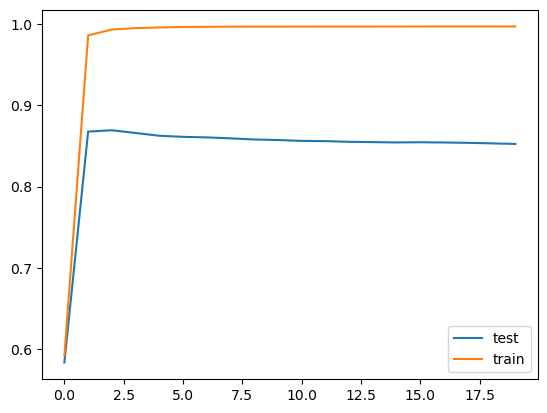

In [111]:
test_scores = linsvc_optimized.cv_results_['mean_test_score']
train_scores = linsvc_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [112]:
linsvc_optimized_predict = linsvc_optimized.predict(X_test_idf_lemm)
print(classification_report(Y_test, linsvc_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       948
         1.0       0.87      0.77      0.82       494

    accuracy                           0.88      1442
   macro avg       0.88      0.85      0.86      1442
weighted avg       0.88      0.88      0.88      1442



**Дерево решений**

In [113]:
dectree_params = {
                  'max_depth': np.arange (80, 160, 10),
                  'min_samples_leaf': np.arange (1, 16, 4),
                  'min_samples_split': np.arange (60, 100, 1) 
                 }
dectree_optimized = RandomizedSearchCV(dectree, dectree_params, cv=5, scoring='f1_weighted', return_train_score=True)
dectree_optimized.fit(X_train_idf_lemm, Y_train)
dectree_optimized.best_estimator_

DecisionTreeClassifier(max_depth=140, min_samples_split=60, random_state=1)

In [114]:
dectree_optimized.best_score_

0.7639095394050532

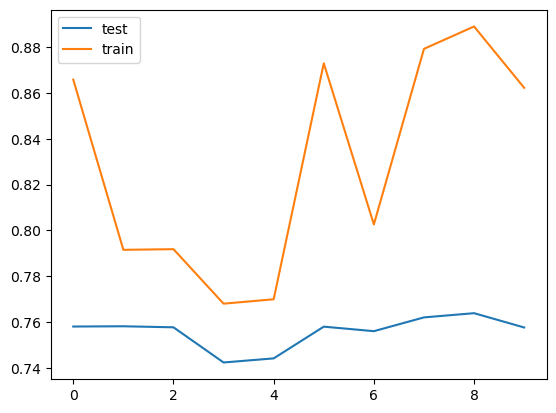

In [115]:
test_scores = dectree_optimized.cv_results_['mean_test_score']
train_scores = dectree_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [116]:
dectree_optimized_predict = dectree_optimized.predict(X_test_idf_lemm)
print(classification_report(Y_test, dectree_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85       948
         1.0       0.77      0.52      0.62       494

    accuracy                           0.78      1442
   macro avg       0.78      0.72      0.73      1442
weighted avg       0.78      0.78      0.77      1442



**Случайный лес**

In [117]:
randfor_params = { 
                'n_estimators': np.arange (1, 100, 1),
                'max_depth': np.arange (1,1000, 20),
                'min_samples_leaf': np.arange (1,50, 1),
                'min_samples_split': np.arange (2,6,1) 
                 }
randfor_optimized = RandomizedSearchCV(randfor, randfor_params, cv=5, scoring='f1_weighted', return_train_score=True)
randfor_optimized.fit(X_train_idf_lemm, Y_train)
randfor_optimized.best_estimator_

RandomForestClassifier(max_depth=921, min_samples_leaf=9, n_estimators=70,
                       random_state=1)

In [118]:
randfor_optimized.best_score_

0.7463785578056512

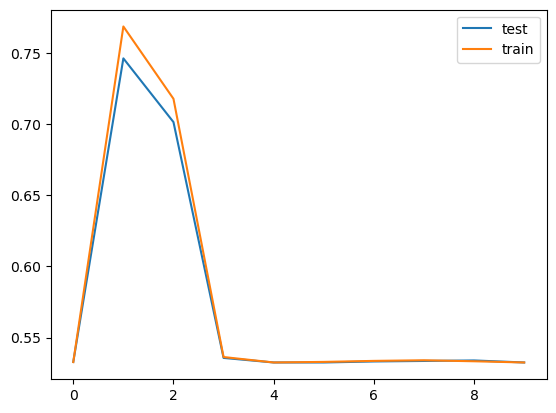

In [119]:
test_scores = randfor_optimized.cv_results_['mean_test_score']
train_scores = randfor_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [120]:
randfor_optimized_predict = randfor_optimized.predict(X_test_idf_lemm)
print(classification_report(Y_test, randfor_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.76      0.98      0.86       948
         1.0       0.93      0.41      0.57       494

    accuracy                           0.79      1442
   macro avg       0.85      0.70      0.71      1442
weighted avg       0.82      0.79      0.76      1442



**Мультиномиальный наивный байесовский классификатор**

In [121]:
MNB_params = { 
                'alpha' : np.arange (0.001, 0.7, 0.01)
             }
MNB_optimized = GridSearchCV(MNB, MNB_params, cv=5, scoring='f1_weighted', return_train_score=True)
MNB_optimized.fit(X_train_idf_lemm, Y_train)
MNB_optimized.best_estimator_

MultinomialNB(alpha=0.10099999999999998)

In [122]:
MNB_optimized.best_score_

0.8796371763199409

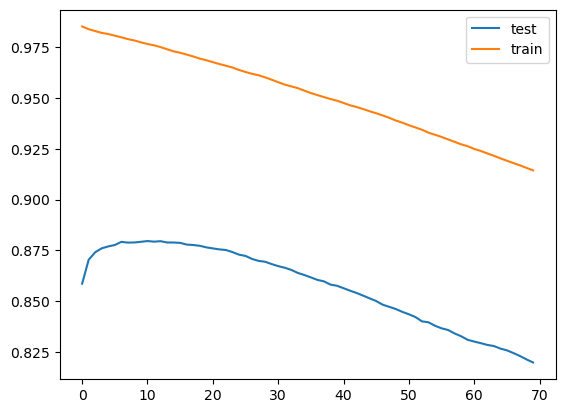

In [123]:
test_scores = MNB_optimized.cv_results_['mean_test_score']
train_scores = MNB_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [124]:
MNB_optimized_predict = MNB_optimized.predict(X_test_idf_lemm)
print(classification_report(Y_test, MNB_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91       948
         1.0       0.86      0.74      0.80       494

    accuracy                           0.87      1442
   macro avg       0.87      0.84      0.85      1442
weighted avg       0.87      0.87      0.87      1442



**K-ближайших соседей**

In [125]:
KNN_params = { 
                'n_neighbors': np.arange (20, 40, 1)
             }
KNN_optimized = GridSearchCV(KNN, KNN_params, cv=5, scoring='f1_weighted', return_train_score=True)
KNN_optimized.fit(X_train_idf_lemm, Y_train)
KNN_optimized.best_estimator_

KNeighborsClassifier(n_neighbors=23)

In [126]:
KNN_optimized.best_score_

0.7900805969283902

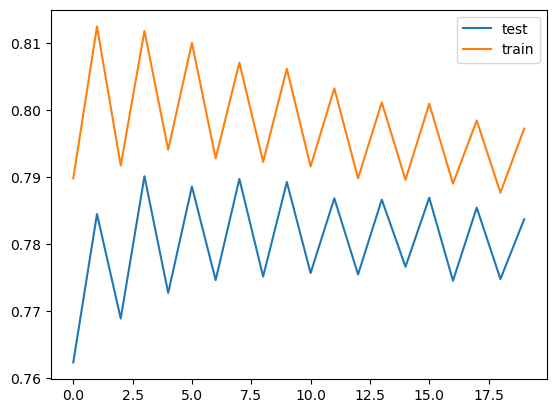

In [127]:
test_scores = KNN_optimized.cv_results_['mean_test_score']
train_scores = KNN_optimized.cv_results_['mean_train_score'] 
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [128]:
KNN_optimized_predict = KNN_optimized.predict(X_test_idf_lemm)
print(classification_report(Y_test, KNN_optimized_predict))

              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87       948
         1.0       0.95      0.48      0.63       494

    accuracy                           0.81      1442
   macro avg       0.87      0.73      0.75      1442
weighted avg       0.84      0.81      0.79      1442



После подбора гиперпараметров виден сильный прирост у Мультиномиального Наивного Байеса. Из-за того, что подбор гиперпараметров методом GridSearch в случаях Дерева Решений и Случайного леса может занимать слишком много времени, было принято решение заменить его на метод RandomizedSearch, который в некоторых случаях может не находить лучших решений.

## Теперь дообучим  LLM и посмотрим её качество: deepvk/deberta-v1-base.

In [170]:
def predict(
    model: AutoModelForSequenceClassification, 
    text: str, 
    return_type: Literal['label', 'score', 'proba'] = 'label',
):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return model.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([0.0, 1.0])
    return proba


def evaluate_model(
    model: AutoModelForSequenceClassification, 
    subset: Optional[int] = None,
):
    Y_pred = []
    
    if subset is None:
        subset = X_test.shape[0]
    
    for x in tqdm(X_test[:subset]):
        prediction = predict(model, x)
        if prediction == "LABEL_1":
            Y_pred.append(1.0)
        elif prediction == "LABEL_0":
            Y_pred.append(0.0)
        
    print(classification_report(Y_test[:subset], Y_pred))

In [144]:
model_checkpoint = 'deepvk/deberta-v1-base'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model_pretrained = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model_pretrained.cuda()

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at deepvk/deberta-v1-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Посмотрим метрики до fine_tune**

In [145]:
evaluate_model(model_pretrained)

  0%|          | 0/1442 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.80       948
         1.0       0.66      0.07      0.13       494

    accuracy                           0.67      1442
   macro avg       0.67      0.53      0.47      1442
weighted avg       0.67      0.67      0.57      1442



Не очень впечатляющие результаты

**Подготовим данные**

In [146]:
n_train_examples = 9970
n_dev_examples = 3000
train_df = pd.DataFrame(
    {
        'text': X_train[:n_train_examples],
        'label': Y_train[:n_train_examples],
    }
)
dev_df = pd.DataFrame(
    {
        'text': X_train[n_train_examples:n_train_examples + n_dev_examples],
        'label': Y_train[n_train_examples:n_train_examples + n_dev_examples],
    }
)

data = DatasetDict(
    {
        'train': Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True)),
        'dev': Dataset.from_pandas(dev_df[['text', 'label']].reset_index(drop=True)),
    }
)
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9970
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 3000
    })
})

In [147]:
all_labels = [0.0, 1.0]
data_tokenized = data.map(
    lambda row: tokenizer(row['text'], truncation=True), batched=True, remove_columns=['text']
)
data_tokenized = data_tokenized.map(
    lambda row: {'label': [all_labels.index(label) for label in row['label']]}, batched=True
)
data_tokenized

Map:   0%|          | 0/9970 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9970 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 9970
    })
    dev: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)

training_args = TrainingArguments(
    output_dir='deberta-v1-base_test', 
    evaluation_strategy='epoch',
)
metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(
        predictions=predictions, 
        references=labels,
    )

trainer = Trainer(
    model=model_pretrained,
    args=training_args,
    train_dataset=data_tokenized['train'],
    eval_dataset=data_tokenized['dev'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [149]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.437600,0.587584,0.524188
2,0.522700,0.499671,0.728120
3,0.288700,0.285763,0.857438


TrainOutput(global_step=3741, training_loss=0.41545062153073625, metrics={'train_runtime': 429.0876, 'train_samples_per_second': 69.706, 'train_steps_per_second': 8.718, 'total_flos': 2292369432837072.0, 'train_loss': 0.41545062153073625, 'epoch': 3.0})

In [152]:
my_checkpoint = r"C:\Users\neytr\3. Binary Classification\deberta-v1-base_test\checkpoint-3500"
tokenizer = AutoTokenizer.from_pretrained('deepvk/deberta-v1-base')
model_finetuned = AutoModelForSequenceClassification.from_pretrained(my_checkpoint)
if torch.cuda.is_available():
    model_pretrained.cuda()

**Посмотрим метрики после дообучения**

In [153]:
evaluate_model(model_finetuned)

  0%|          | 0/1442 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       948
         1.0       0.88      0.85      0.87       494

    accuracy                           0.91      1442
   macro avg       0.90      0.90      0.90      1442
weighted avg       0.91      0.91      0.91      1442



Очень сильный прирост метрик, что очень радует.